In [2]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os,tabulate
from sklearn.linear_model import LinearRegression
from statsmodels.formula.api import ols


In [3]:
# First we have to load our dataset into python for further processing and analytics
def loading_datasets(filename,filename1,filename2):
        path = os.path.abspath('C:/Users/Balli/Pictures/FourDataFile/')
        if path:
            fullpath = os.path.join(path,filename)
            fullpath1 = os.path.join(path,filename1)
            fullpath2 = os.path.join(path,filename2)
            t_dataset = pd.read_csv(fullpath)
            p_dataset = pd.read_csv(fullpath1)
            s_dataset = pd.read_csv(fullpath2)
# Note PT means Product and transaction dataset
            df = t_dataset.copy()
            df1 = p_dataset.copy()
            df2 = s_dataset.copy()
            pt_dataset = pd.merge(df,df1, on='UPC', how='left')
            print(tabulate.tabulate(pt_dataset.reset_index(drop=True).head(100),headers=pt_dataset.columns.tolist(),tablefmt='heavy_grid'))
            return pt_dataset
        raise FileNotFoundError(f"Directory {path} does not exist.")



In [4]:
def featureengineering(df):
    if not df.empty:
        for column in df.columns:
            if column in ['PRICE','BASE_PRICE']:
                df.fillna({column:df[column].mean()}, inplace=True)
                df[column] = df[column].apply(lambda x: df[column].mode()[0] if x == 0 else x)

# Add a column for log-transformed sales and price we need this column so that we can predict product responsiveness 
# to price changes without skewness to avoid noise in the model
        df['log_sales'] = np.log(df['SPEND'] + 1) # + 1 to reduce the skewness of our data by round 0s to 1 
        df['log_price'] = np.log(df['PRICE'] + 1)# + 1 to reduce the skewness of our data by round 0s to 1 
        return df
                
    return "Empty Dataframe"



In [5]:
#QUESTION 1
# To get the  production that is most sensitve to price. we are going to compute price change  in relation to sales
# and we are going to make use of linear regression analysis OLS predict sales given every one dollar change in price

def most_price_sensitive_product(df):
    if not df.empty:
        price_sensitivity = {}
        for product in df['UPC'].unique():
            product_dataset = df[df['UPC'] == product]
            model = ols('log_sales ~ log_price', data=product_dataset).fit()
            price_sensitivity[product] = round(model.params['log_price'],2)

# Sort products by price sensitivity
        sorted_price_sensitivity = sorted(price_sensitivity.items(),key=lambda x:abs(x[1]), reverse=True)
        price_sensitivity_df = pd.DataFrame(sorted_price_sensitivity, columns = ('Product_id','Coefficient'))
        print(f'Products most price sensitive:\n{tabulate.tabulate(price_sensitivity_df.set_index('Product_id'),headers=price_sensitivity_df.columns.tolist(),tablefmt='heavy_grid')}')

# Plotting a graph to better explain price elasticity
        plt.hist([v for  v in price_sensitivity.values() if not pd.isnull(v)], bins=30)
        plt.title('Distribution of Price Sensitivity')
        plt.xlabel('Elasticity Coefficient')
        plt.ylabel('Number of Products')
        plt.show()
        return df
    else:
        print("Empty Dataframe")


In [6]:
#QUESTION 2 SOLUTION
def aggregate_sales_monthcategory(df):
# Aggregate sales by month and category
# Converting Week end date to a date format
    if not df.empty:
        df['DATE']=pd.to_datetime(df['WEEK_END_DATE'],format='%d-%b-%y')

# Extracting month from the date to relay seasonal trend
        df['MONTH'] = df['DATE'].dt.to_period('M')
        seasonal_sales = df.groupby(['MONTH', 'CATEGORY'])['log_sales'].mean().unstack()

# Plot seasonal sales patterns
        seasonal_sales.plot(figsize=(10, 5))
        plt.title('Seasonal Sales Patterns by Category')
        plt.xlabel('Month')
        plt.ylabel('Average Sales')
        plt.show()
        return df


In [7]:
#QUESTION 3 SOLUTION

def influence_of_promotion(df):
    
        if not df.empty:
                df['FEATURE']= df['FEATURE'].apply(lambda x: 'Promo Applied' if x == 1 else 'Promo Not-Applied')

                df['DISPLAY']= df['DISPLAY'].apply(lambda x: 'Promo Applied' if x == 1 else 'Promo Not-Applied')

                df['TPR_ONLY']= df['TPR_ONLY'].apply(lambda x: 'Promo Applied' if x == 1 else 'Promo Not-Applied')


# Aggregate sales by promotion(display, feature and tempral price reduction TPR)
                feature_promo= df.groupby('FEATURE')['log_sales'].mean().reset_index()
                display_promo = df.groupby('DISPLAY')['log_sales'].mean().reset_index()
                tpr_only_promo= df.groupby('TPR_ONLY')['log_sales'].mean().reset_index()


# Plot the impacts
                fig, ax = plt.subplots(1, 3, figsize=(12, 6))
                sns.barplot(x=feature_promo['FEATURE'], y=feature_promo['log_sales'], ax=ax[0])
                ax[0].set_title('Impact of Feature Promotions on Sales')
                ax[0].set_xlabel('Feature Promotion')
                ax[0].set_ylabel('Average Sales')

                sns.barplot(x=display_promo['DISPLAY'], y=display_promo['log_sales'], ax=ax[1])
                ax[1].set_title('Impact of Displays on Sales')
                ax[1].set_xlabel('Display Promotion')
                ax[1].set_ylabel('Average Sales')

                sns.barplot(x=tpr_only_promo['TPR_ONLY'], y=tpr_only_promo['log_sales'], ax=ax[2])
                ax[2].set_title('Impact of TPR on Sales')
                ax[2].set_xlabel('TPR_ONLY Promotion')
                ax[2].set_ylabel('Average Sales')
                plt.show()
        return df


In [8]:
#QUESTION 4
def sales_trend(df):
# TO find trend in sales of a product category we will aggregate sales by date and product category
    if not df.empty:
        trend_dataset = df.groupby(['DATE', 'CATEGORY'])['log_sales'].sum().unstack()

# Plot sales trends over time
        trend_dataset.plot(figsize=(12, 6))
        plt.title('Sales Trends Over Time by Category')
        plt.xlabel('Date')
        plt.ylabel('Total Sales')
        plt.show()


┏━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┓
┃    ┃ WEEK_END_DATE   ┃   STORE_NUM ┃         UPC ┃   UNITS ┃   VISITS ┃   HHS ┃   SPEND ┃   PRICE ┃   BASE_PRICE ┃   FEATURE ┃   DISPLAY ┃   TPR_ONLY ┃ DESCRIPTION               ┃ MANUFACTURER   ┃ CATEGORY              ┃ SUB_CATEGORY                ┃ PRODUCT_SIZE   ┃
┣━━━━╋━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━╋━━━━━━━━━━━━━╋━━━━━━━━━╋━━━━━━━━━━╋━━━━━━━╋━━━━━━━━━╋━━━━━━━━━╋━━━━━━━━━━━━━━╋━━━━━━━━━━━╋━━━━━━━━━━━╋━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━┫
┃  0 ┃ 14-Jan-09       ┃         367 ┃  1111009477 ┃      13 ┃       13 ┃    13 ┃   18.07 ┃    1.39 ┃         1.57 ┃         0 ┃         0 ┃          1 ┃ PL MINI TWIST PRETZELS    ┃ PRIVATE 

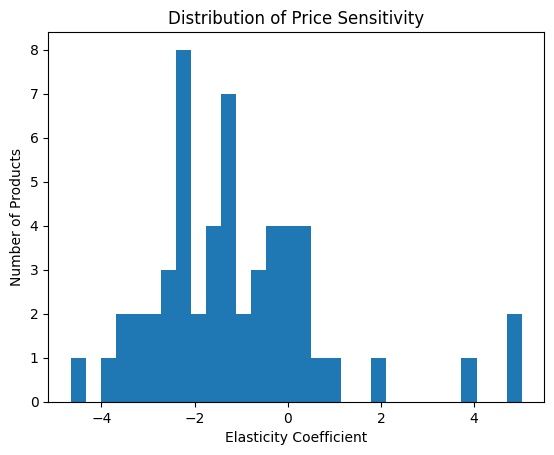

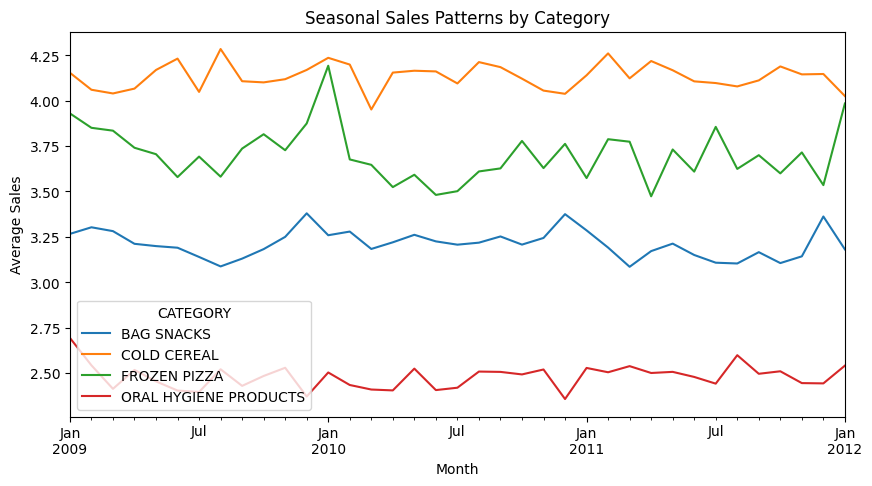

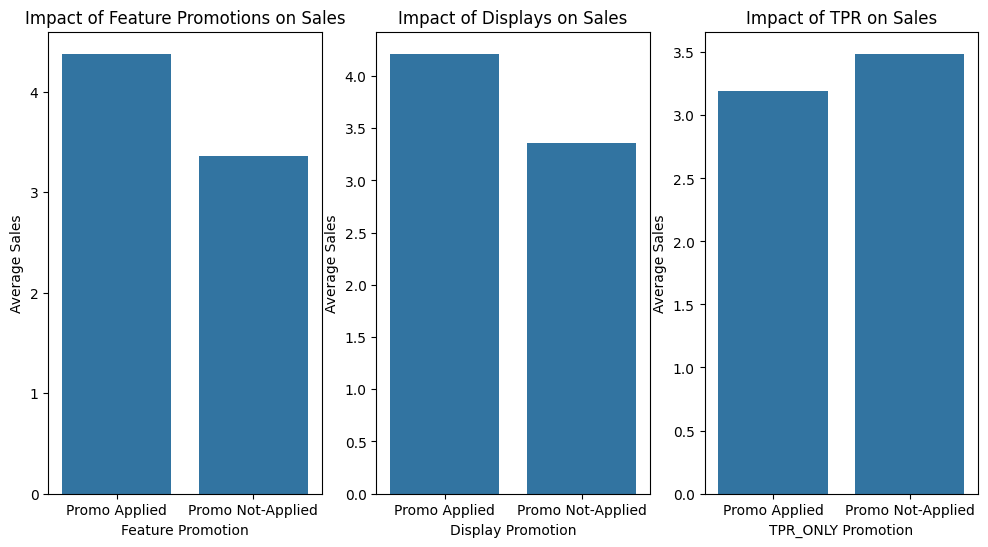

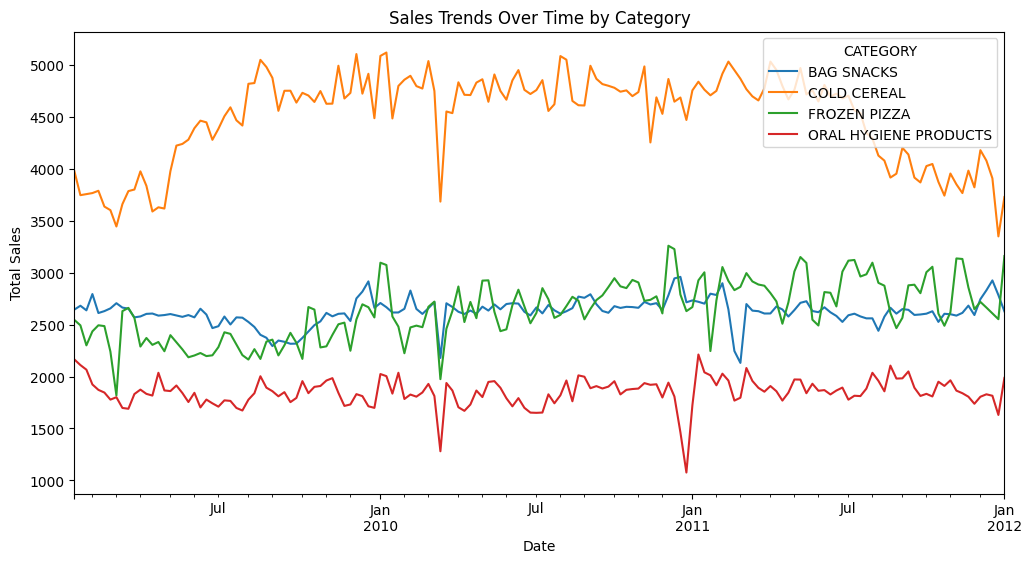

In [9]:
file_import = loading_datasets('fw-transaction-data.csv','fw-product-lookup.csv','fw-store-lookup.csv')
Engineer_Dataset = featureengineering(file_import)
Most_price_sensitive_product = most_price_sensitive_product(Engineer_Dataset)
Totalsales_bymonth = aggregate_sales_monthcategory(Most_price_sensitive_product)
Influence_of_promo_on_sales = influence_of_promotion(Totalsales_bymonth)
Sales_trend = sales_trend(Influence_of_promo_on_sales)